In [1]:
"""
@author: albertigno

"""

from MyDataset import *
from snn_models_with_delay import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

Running on: cuda:0


In [2]:
thresh = 0.3
batch_size = 256 # default 256
learning_rate = 1e-4 # default 1e-4
time_window = 50 # shd 50, nmnist 25-30
dataset_path = r'./../../datasets'

In [3]:
train_path = dataset_path+'/shd_digits/shd_train.h5'
test_path = dataset_path+'/shd_digits/shd_test.h5'
# load datasets
print("loading test set...")
test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)
print("loading training set...")
train_dataset = MyDataset(train_path, 'hd_digits', time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 2264
torch.Size([2264, 50, 700]) torch.Size([2264, 20])
loading training set...
num sample: 8156
torch.Size([8156, 50, 700]) torch.Size([8156, 20])
loading data with pytorch


In [4]:
tau_m = 'adp'
#tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn = RSNN('shd', num_hidden=512, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

RSNN(
  (fc_ih): Linear(in_features=700, out_features=512, bias=False)
  (fc_hh): Linear(in_features=512, out_features=512, bias=False)
  (fc_ho): Linear(in_features=512, out_features=20, bias=False)
)

In [5]:
# training configuration

num_epochs = 20
modelname = 'shd_rnn_{}_{}.t7'.format(snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn.fc_ih.weight,
               snn.fc_hh.weight,
               snn.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

tau_m_h 
shd_rnn_512_adp.t7


In [6]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if epoch % 5 ==0:
        snn.test(test_loader, criterion=nn.MSELoss())
        snn.save_model(modelname)   

Epoch [1/20]
Step [10/31], Loss: 0.48793
Step [20/31], Loss: 0.47289
Step [30/31], Loss: 0.46072
Time elasped: 2.932971954345703
Test Accuracy of the model on the test samples: 19.043
Epoch [2/20]
Step [10/31], Loss: 0.44938
Step [20/31], Loss: 0.44080
Step [30/31], Loss: 0.43605
Time elasped: 2.4243862628936768
Epoch [3/20]
Step [10/31], Loss: 0.42493
Step [20/31], Loss: 0.42192
Step [30/31], Loss: 0.41346
Time elasped: 2.40099835395813
Epoch [4/20]
Step [10/31], Loss: 0.40434
Step [20/31], Loss: 0.40053
Step [30/31], Loss: 0.39305
Time elasped: 2.3872475624084473
Epoch [5/20]
Step [10/31], Loss: 0.38117
Step [20/31], Loss: 0.36654
Step [30/31], Loss: 0.36011
Time elasped: 2.3919525146484375
Epoch [6/20]
Step [10/31], Loss: 0.34607
Step [20/31], Loss: 0.34167
Step [30/31], Loss: 0.33969
Time elasped: 2.3958990573883057
Test Accuracy of the model on the test samples: 54.395
Epoch [7/20]
Step [10/31], Loss: 0.33143
Step [20/31], Loss: 0.32726
Step [30/31], Loss: 0.32699
Time elasped: 2.

In [7]:
snn.save_to_numpy(modelname.split('.')[0])

<AxesSubplot:ylabel='Count'>

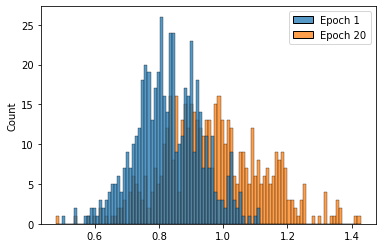

In [8]:
import seaborn as sns
import pandas as pd

initial_taus = taus_m[0][0].cpu().numpy()
final_taus = taus_m[-1][0].cpu().numpy()

df = pd.DataFrame(initial_taus, columns=['Epoch 1'])
df['Epoch {}'.format(len(taus_m))] = final_taus

sns.histplot(data=df, bins=100)

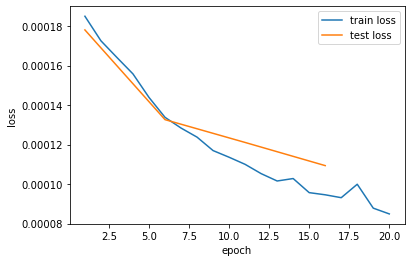

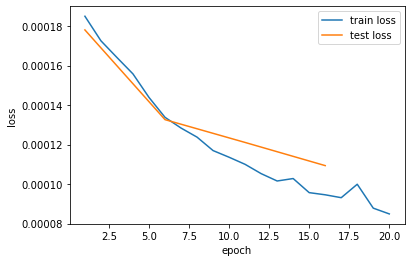

In [9]:
snn.plot_loss()

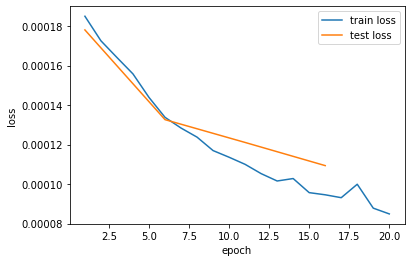

In [10]:
loss_fig = snn.plot_loss()

In [11]:
m = RSNN()

In [12]:
m.load_model(modelname, 256, device)

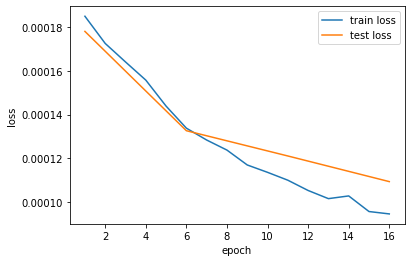

In [14]:
loss_fig = m.plot_loss()